In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv as StockTradingEnv_numpy
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.neo_finrl.data_processor import DataProcessor


from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import ray
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/hcaoaf/.local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [4]:
# from config.py end_date is a string
config.END_DATE

'2021-10-31'

In [5]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [12]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-07-06',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
print(df.shape)

(91870, 8)


In [14]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.617247,607541200,AAPL,2
1,2008-12-31,57.110001,58.220001,57.060001,45.031918,6287200,AMGN,2
2,2008-12-31,17.969999,18.750000,17.910000,14.988304,9625600,AXP,2
3,2008-12-31,41.590000,43.049999,41.500000,32.005886,5443100,BA,2
4,2008-12-31,43.700001,45.099998,43.700001,30.925039,6277400,CAT,2


# Preprocess Data

In [15]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list= config.TECHNICAL_INDICATORS_LIST, 
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)
processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3148, 8)
Successfully added vix
Successfully added turbulence index


In [16]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [17]:
processed_full.sort_values(['date','tic'], ignore_index=True).head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.617247,607541200.0,2.0,0.0,2.934224,2.465861,100.0,66.666667,100.0,2.617247,2.617247,40.0,0.0
1,2008-12-31,AMGN,57.110001,58.220001,57.060001,45.031918,6287200.0,2.0,0.0,2.934224,2.465861,100.0,66.666667,100.0,45.031918,45.031918,40.0,0.0
2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.988304,9625600.0,2.0,0.0,2.934224,2.465861,100.0,66.666667,100.0,14.988304,14.988304,40.0,0.0
3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005886,5443100.0,2.0,0.0,2.934224,2.465861,100.0,66.666667,100.0,32.005886,32.005886,40.0,0.0
4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.925039,6277400.0,2.0,0.0,2.934224,2.465861,100.0,66.666667,100.0,30.925039,30.925039,40.0,0.0


# Design Env

In [18]:
train = data_split(processed_full, start='2009-01-01', end='2020-07-01')
trade = data_split(processed_full, start='2020-07-01', end='2021-07-06')
print(len(train), len(trade))

83897 7337


In [19]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,289.569733,2932900.0,1.0,-0.019601,305.819486,272.941232,52.413035,-25.789812,1.846804,289.815179,282.752198,30.43,12.918769
2892,2020-06-30,V,191.490005,193.750000,190.160004,191.749405,9040100.0,1.0,1.054352,199.805209,186.023338,53.021034,-51.499737,2.013358,192.501169,182.641771,30.43,12.918769
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,51.604496,17414800.0,1.0,-0.447764,55.232496,49.916929,48.097038,-50.926655,8.508886,52.255362,52.718948,30.43,12.918769
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,40.278057,4782100.0,1.0,-0.086659,43.965358,37.648309,48.830182,-14.417185,1.500723,40.380679,40.174252,30.43,12.918769
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,117.465675,6836400.0,1.0,-0.896831,120.856467,114.824139,48.159663,-69.901754,3.847271,119.150817,121.108865,30.43,12.918769


In [20]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.282990,110737200.0,2.0,3.027292,93.089462,80.517396,62.807156,107.485318,29.730532,84.287015,78.044629,28.620001,53.068016
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,246.209015,6575800.0,2.0,3.728076,238.256908,205.260963,61.279629,271.963497,46.806139,220.275944,221.376001,28.620001,53.068016
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.579552,3301000.0,2.0,-0.391245,111.015321,88.229334,48.504817,-66.339667,3.142448,97.765433,91.181246,28.620001,53.068016
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068016
0,2020-07-01,CAT,129.380005,129.399994,125.879997,121.818481,2807800.0,2.0,1.284937,131.887570,114.449384,52.865421,35.546933,14.457404,120.567699,114.745772,28.620001,53.068016


In [14]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [21]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

# build gym
e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [23]:
# environment for training
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Implement DRL Algorithms

In [24]:
agent = DRLAgent(env = env_train)

## Model1: A2C

In [28]:
model_a2c = agent.get_model(model_name='a2c')

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [29]:
training_a2c = agent.train_model(
    model=model_a2c,
    tb_log_name='a2c',
    total_timesteps=50000
)

Logging to tensorboard_log/a2c/a2c_1
---------------------------------------
| time/                 |             |
|    fps                | 107         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -0.22       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 25.5        |
|    reward             | -0.23112771 |
|    std                | 1           |
|    value_loss         | 0.47        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 112         |
|    iterations         | 200         |
|    time_elapsed       | 8           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -41.3       |
|  

## Model2: DDPG

In [30]:
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [31]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_1
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3880195.42
total_reward: 2880195.42
total_cost: 5213.92
total_trades: 40421
Sharpe: 0.690
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 71       |
|    time_elapsed    | 162      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | -23.9    |
|    critic_loss     | 1.84e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 5.262882 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 70       |
|    time_elapsed    | 327      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 13.5     |
|    critic_loss     | 17.4     |
|    learning_rate   | 0.001    |
|    n_updates     

## Model3: PPO

In [32]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [33]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

Logging to tensorboard_log/ppo/ppo_1
---------------------------------
| time/              |          |
|    fps             | 134      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 0.413404 |
---------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 2          |
|    time_elapsed         | 33         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01629251 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | 0.0415     |
|    learning_rate        | 0.00025    |
|    loss                 | 6.57       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0231    |
|

## Model4: TD3

In [34]:
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [35]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_1
day: 2892, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 4668520.06
total_reward: 3668520.06
total_cost: 1001.33
total_trades: 52056
Sharpe: 0.799
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 88        |
|    time_elapsed    | 130       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 121       |
|    critic_loss     | 2.57e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 4.3169436 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 83        |
|    time_elapsed    | 278       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 44.6      |
|    critic_loss     | 2.46e+03  |
|    learning_rate   | 0.001     

## Model5: SAC

In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [27]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

Logging to tensorboard_log/sac/sac_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 30       |
|    time_elapsed    | 373      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 1.43e+03 |
|    critic_loss     | 561      |
|    ent_coef        | 0.256    |
|    ent_coef_loss   | -24.5    |
|    learning_rate   | 0.0001   |
|    n_updates       | 11471    |
|    reward          | 6.108671 |
---------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 27        |
|    time_elapsed    | 856       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 560       |
|    critic_loss     | 159       |
|    ent_coef        | 0.0846    |
|    ent_coef_loss   | -107      |
|    learning_rate   | 0.0001    |
|    n_updates       | 23043     

# Trading

Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [28]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]

In [29]:
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [33]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [30]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [31]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574232
std        43.787168
min         0.000000
25%        14.966338
50%        24.124579
75%        39.162424
max       652.503895
Name: turbulence, dtype: float64

In [32]:
insample_risk_indicator.turbulence.quantile(0.996)

276.4528315237581

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-06 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [34]:
e_trade_gym = StockTradingEnv(
    df = trade,
    turbulence_threshold=70,
    risk_indicator_col='vix',
    **env_kwargs
)

In [35]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.282990,110737200.0,2.0,3.027292,93.089462,80.517396,62.807156,107.485318,29.730532,84.287015,78.044629,28.620001,53.068016
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,246.209015,6575800.0,2.0,3.728076,238.256908,205.260963,61.279629,271.963497,46.806139,220.275944,221.376001,28.620001,53.068016
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.579552,3301000.0,2.0,-0.391245,111.015321,88.229334,48.504817,-66.339667,3.142448,97.765433,91.181246,28.620001,53.068016
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068016
0,2020-07-01,CAT,129.380005,129.399994,125.879997,121.818481,2807800.0,2.0,1.284937,131.887570,114.449384,52.865421,35.546933,14.457404,120.567699,114.745772,28.620001,53.068016


In [36]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model = trained_sac,
    environment = e_trade_gym
)

hit end!


In [40]:
print(df_account_value.shape)
print(df_actions.shape)

(253, 2)
(252, 29)


# BackTest

## BackTest Stats

In [42]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.250596
Cumulative returns     0.251707
Annual volatility      0.148737
Sharpe ratio           1.584268
Calmar ratio           2.517275
Stability              0.885863
Max drawdown          -0.099551
Omega ratio            1.304797
Sortino ratio          2.336795
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.962107
Daily value at risk   -0.017804
dtype: float64


In [43]:
# baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
    ticker='^DJI',
    start=df_account_value.loc[0,'date'],
    end=df_account_value.loc[len(df_account_value)-1,'date']
)
stats = backtest_stats(baseline_df, value_col_name='close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
Annual return          0.335107
Cumulative returns     0.336639
Annual volatility      0.145596
Sharpe ratio           2.066650
Calmar ratio           3.752275
Stability              0.946226
Max drawdown          -0.089308
Omega ratio            1.410677
Sortino ratio          3.094274
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.081322
Daily value at risk   -0.017149
dtype: float64


In [44]:
print('start:', df_account_value.loc[0,'date'], 'end:',df_account_value.loc[len(df_account_value)-1,'date'])

start: 2020-07-01 end: 2021-07-01


## BackTestPlot

==============Compare to DJI===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-07-01
End date,2021-07-01
Total months,12
,Backtest
Annual return,25.06%
Cumulative returns,25.171%
Annual volatility,14.874%
Sharpe ratio,1.58
Calmar ratio,2.52
Stability,0.89
Max drawdown,-9.955%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.96,2020-09-02,2020-10-30,2020-11-16,54
1,7.06,2021-01-26,2021-03-04,2021-03-22,40
2,6.0,2021-05-10,2021-06-18,NaT,NaN
3,3.52,2020-07-22,2020-07-31,2020-08-10,14
4,2.53,2020-11-16,2020-11-20,2020-11-27,10


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.09%,-3.21%,2.65%


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


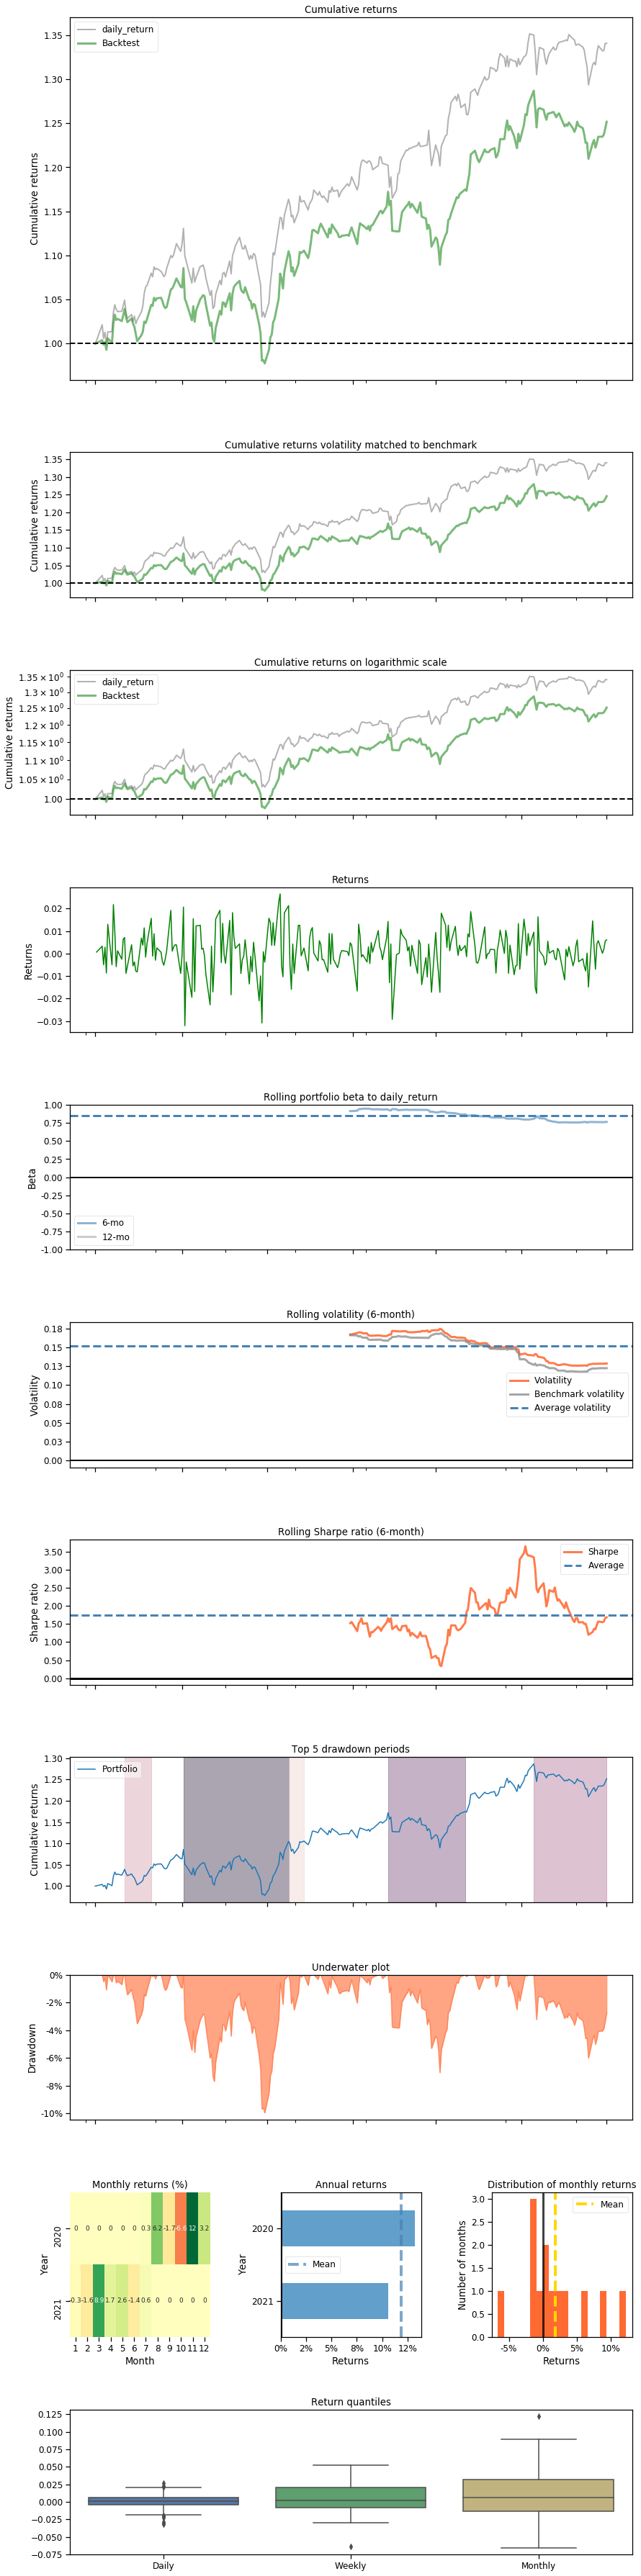

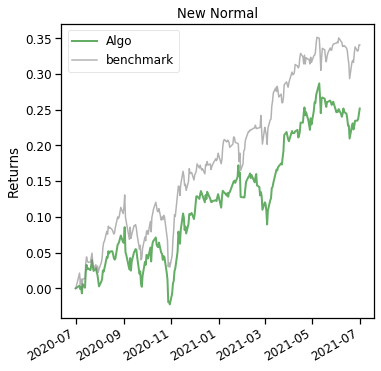

In [45]:
print("==============Compare to DJI===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(
    account_value=df_account_value,
    baseline_ticker='^DJI',
    baseline_start=df_account_value.loc[0,'date'],
    baseline_end=df_account_value.loc[len(df_account_value)-1,'date']
)

# Second SAC Model Train & Trade & BackTest

Training Phrase

In [48]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [49]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

Logging to tensorboard_log/sac/sac_2
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 33        |
|    time_elapsed    | 348       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 368       |
|    critic_loss     | 52.8      |
|    ent_coef        | 0.111     |
|    ent_coef_loss   | -103      |
|    learning_rate   | 0.0001    |
|    n_updates       | 11471     |
|    reward          | 2.6979494 |
----------------------------------
day: 2892, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2949493.44
total_reward: 1949493.44
total_cost: 16113.66
total_trades: 48742
Sharpe: 0.485
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 30        |
|    time_elapsed    | 761       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 121      

Trading phrase

In [50]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [51]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


BackTest Phrase

In [52]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.409532
Cumulative returns     0.411453
Annual volatility      0.149417
Sharpe ratio           2.382402
Calmar ratio           5.045008
Stability              0.959442
Max drawdown          -0.081176
Omega ratio            1.494658
Sortino ratio          3.689053
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.246610
Daily value at risk   -0.017412
dtype: float64


In [53]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
Annual return          0.335107
Cumulative returns     0.336639
Annual volatility      0.145596
Sharpe ratio           2.066650
Calmar ratio           3.752275
Stability              0.946226
Max drawdown          -0.089308
Omega ratio            1.410677
Sortino ratio          3.094274
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.081322
Daily value at risk   -0.017149
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-07-01
End date,2021-07-01
Total months,12
,Backtest
Annual return,40.953%
Cumulative returns,41.145%
Annual volatility,14.942%
Sharpe ratio,2.38
Calmar ratio,5.05
Stability,0.96
Max drawdown,-8.118%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.12,2020-09-02,2020-10-30,2020-11-16,54
1,5.88,2021-06-04,2021-06-18,NaT,NaN
2,3.83,2021-02-24,2021-02-26,2021-03-10,11
3,3.75,2021-01-13,2021-01-29,2021-02-04,17
4,3.7,2021-05-10,2021-05-12,2021-05-27,14


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.14%,-3.09%,3.52%


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


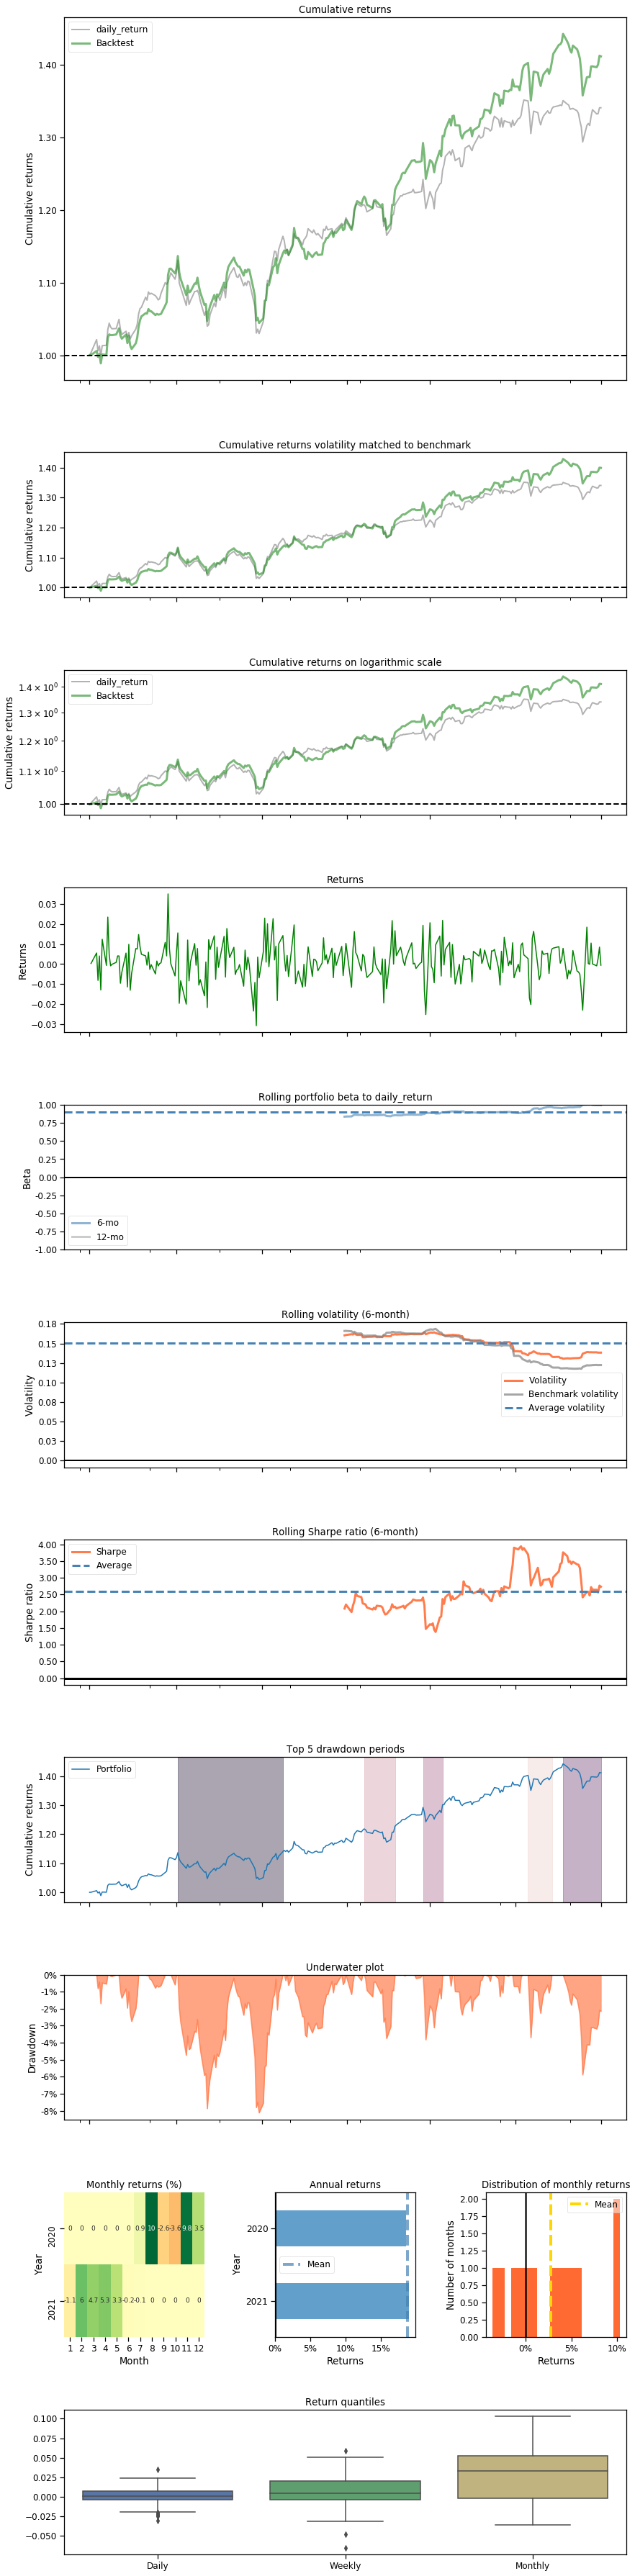

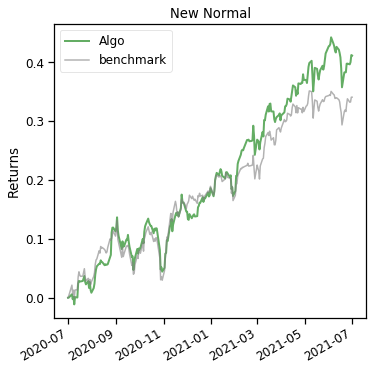

In [54]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

# Third SAC Model Train & Trade & BackTest

Training Phrase

In [55]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [56]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

Logging to tensorboard_log/sac/sac_3
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 22         |
|    time_elapsed    | 509        |
|    total_timesteps | 11572      |
| train/             |            |
|    actor_loss      | 646        |
|    critic_loss     | 1.22e+03   |
|    ent_coef        | 0.14       |
|    ent_coef_loss   | -91.4      |
|    learning_rate   | 0.0001     |
|    n_updates       | 11471      |
|    reward          | -13.666498 |
-----------------------------------
day: 2892, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 5165854.85
total_reward: 4165854.85
total_cost: 35343.05
total_trades: 58204
Sharpe: 0.808
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 22       |
|    time_elapsed    | 1017     |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 2

Trading phrase

In [57]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [58]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


BackTest Phrase

In [59]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.333286
Cumulative returns     0.334809
Annual volatility      0.144248
Sharpe ratio           2.075084
Calmar ratio           4.220877
Stability              0.952955
Max drawdown          -0.078961
Omega ratio            1.419244
Sortino ratio          3.130137
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.086769
Daily value at risk   -0.016986
dtype: float64


In [60]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
Annual return          0.335107
Cumulative returns     0.336639
Annual volatility      0.145596
Sharpe ratio           2.066650
Calmar ratio           3.752275
Stability              0.946226
Max drawdown          -0.089308
Omega ratio            1.410677
Sortino ratio          3.094274
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.081322
Daily value at risk   -0.017149
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-07-01
End date,2021-07-01
Total months,12
,Backtest
Annual return,33.329%
Cumulative returns,33.481%
Annual volatility,14.425%
Sharpe ratio,2.08
Calmar ratio,4.22
Stability,0.95
Max drawdown,-7.896%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.9,2020-09-02,2020-10-28,2020-11-09,49
1,3.56,2021-01-20,2021-01-29,2021-02-08,14
2,3.51,2021-05-07,2021-06-18,NaT,NaN
3,3.17,2021-02-24,2021-03-04,2021-03-08,9
4,2.86,2020-07-22,2020-07-31,2020-08-05,11


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.12%,-3.49%,3.05%


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


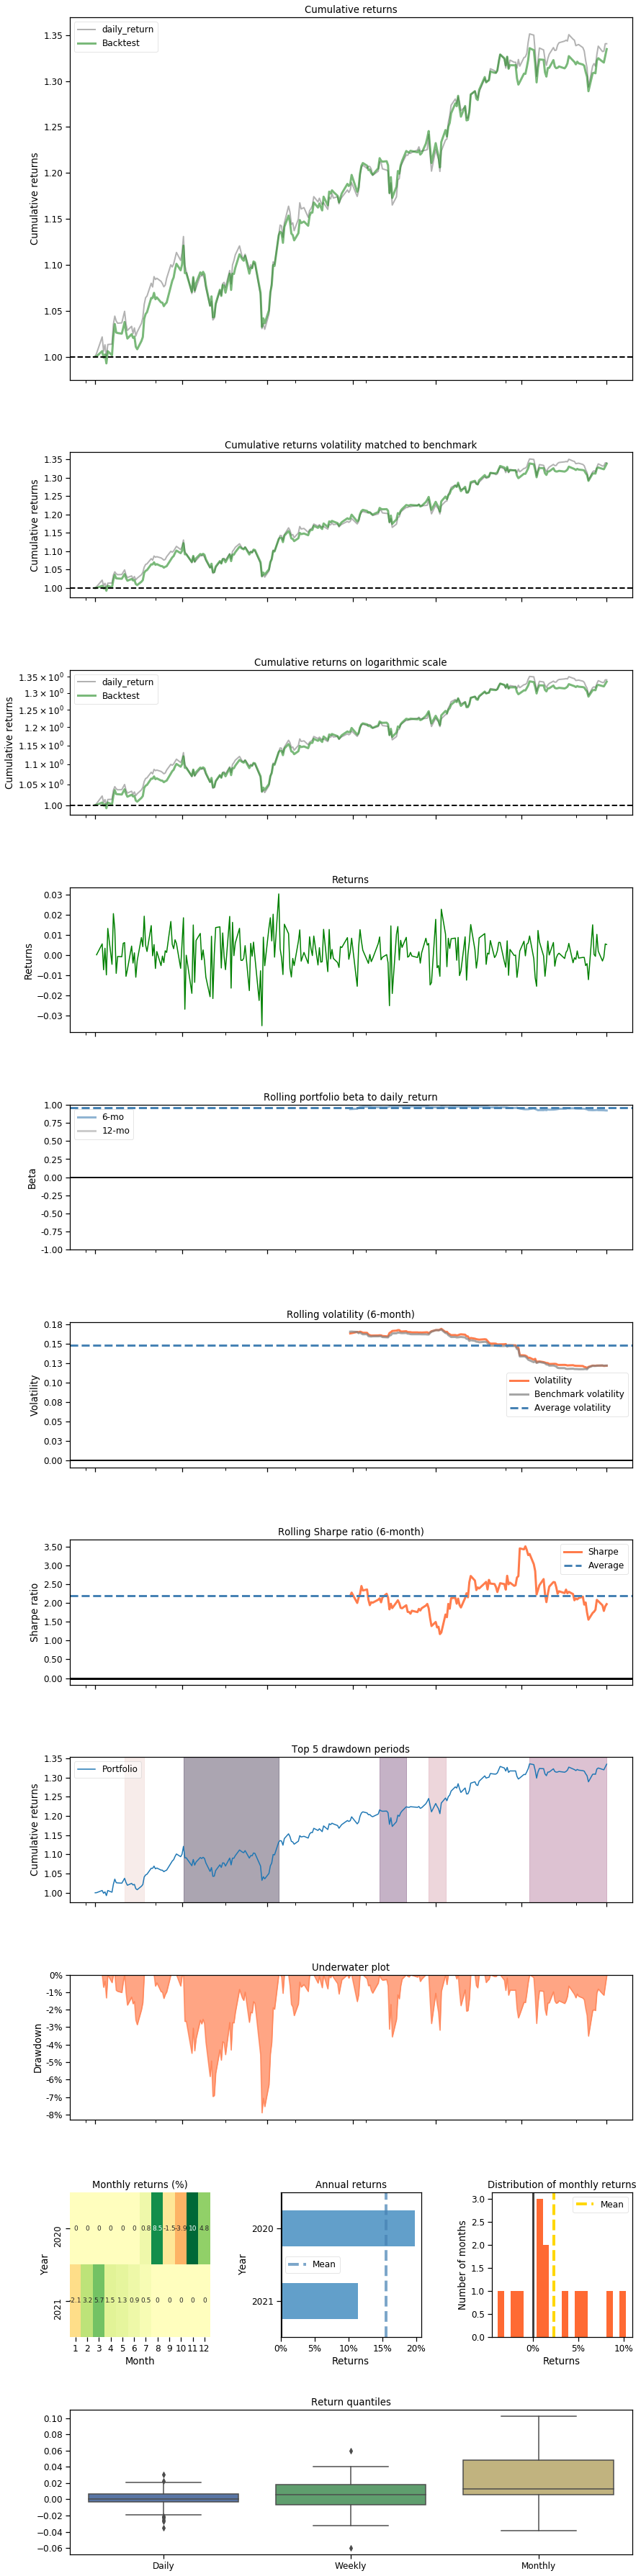

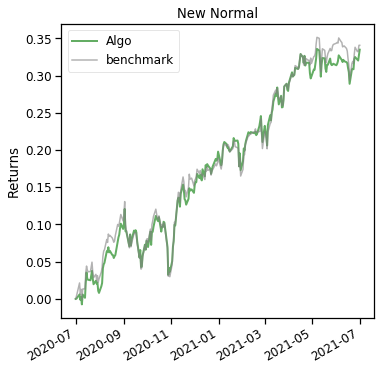

In [61]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])